# AnnualCycle

In [13]:
# imports
from importlib import reload
import os

import numpy as np
from scipy.interpolate import interp1d
from scipy.io import loadmat

import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import seaborn as sns

from siosandbox.cugn import clusters
from siosandbox.cugn import grid_utils
from siosandbox.cugn import io as cugn_io
from siosandbox import plot_utils
from siosandbox.cugn import annualcycle

from gsw import conversions, density
import gsw

# Load the .mat file

In [3]:
anncyc90_file = os.path.join(os.getenv('CUGN'), 'anncyc90.mat')

In [4]:
anncyc90 = loadmat(anncyc90_file)

In [12]:
type(Adict['A'])

numpy.ndarray

In [6]:
anncyc90.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A', 'avmap', 'avmapnomean', 'avmapnomeantm', 'avmapsig', 'avmapsignomean', 'avmaptm', 'ctd', 'meanmap', 'meanmapsig', 'meanmaptm'])

In [50]:
# 5: xcenter [107]
# 6: Gaussian
# 7: Depth [50]
# 8: lon
# 9: salinity?
# 10: coeff for one of the variables
# anncyc90['A'][0][0][10][0][0][0] -- constant 107
# anncyc90['A'][0][0][10][0][0][1] -- 107,3  (sin?)
# anncyc90['A'][0][0][12]['constant'][0][0] -- 50,107   (Almost certainly t)

anncyc90['A'][0][0][10][0][0][2].shape

(107, 3)

In [63]:
#anncyc90['A'][0][0][10]['constant'][0][0] # sin, cos

In [74]:
anncyc90['A'][0][0][12]['constant'][0][0][0,0]

16.997300827492516

In [76]:
anncyc90['A'][0][0][12]['sin'][0][0].shape

(50, 107, 3)

## Unpack for convenience

In [160]:
A = {}
A['t'] = {}
for key in ['constant', 'sin', 'cos']:
    A['t'][key] = anncyc90['A'][0][0][12][key][0][0]
A['xcenter'] = anncyc90['A'][0][0][5][:,0].astype(float)

# Try one

In [108]:
time = np.array([180., 200])
dist = np.array([14., 79.])
level = 2
timebin=2*np.pi*time/86400/365.25

variable = 't'
maxharmonic = A[variable]['sin'].shape[2]
#G = np.vstack([np.ones(len(timebin)), 
#               np.sin(timebin * (np.arange(maxharmonic) + 1)), 
#               np.cos(timebin * (np.arange(maxharmonic) + 1))]).T

In [92]:
G = np.ones((time.size, 1 + 2*maxharmonic))
G.shape

(2, 7)

In [94]:
for kk in range(maxharmonic):
    G[:,kk+1] = np.sin(timebin * (kk+1))
    G[:,kk+4] = np.cos(timebin * (kk+1))

In [103]:
ii = dist <= np.min(A['xcenter'])
ii

array([False, False])

In [161]:
n=0
xx = A['xcenter'] - dist[n]
ip = np.where(xx[:-1] * xx[1:] <= 0)[0][0]
ip

2

In [162]:
A['xcenter'][ip]

10.0

In [147]:
m2 = np.zeros((2,7))
m2[:,0] = A[variable]['constant'][level, ip:ip+2]
m2[:,1:4] = A[variable]['sin'][level, ip:ip+2]
m2[:,4:7] = A[variable]['cos'][level, ip:ip+2]    
m2.shape

(2, 7)

In [148]:
bracket = G[n:n+1,:] @ m2.T
bracket

array([[15.08601338, 15.06415729]])

In [149]:
xx[ip], xx[ip+1]

(array([-4.]), array([1.]))

In [165]:
dx = np.diff(A['xcenter'])

ans =  float(bracket @ [xx[ip+1], -xx[ip]]) / dx[ip]
ans

15.068528504274905

In [166]:
level

2

----

# Try with my method

In [15]:
A = anncyc90 = loadmat(anncyc90_file, variable_names=['A'])['A']

In [20]:
time = np.array([180., 200])
dist = np.array([14., 79.])
level = 2
variable = 't'

#
reload(annualcycle)
annualcycle.evaluate(A, variable, level, time, dist)

array([15.0685285 , 14.93466138])

----

# Generate 2019

In [24]:
dti = pandas.date_range('2019-01-01', periods=365, freq='1D')

In [25]:
time = (dti - pandas.Timestamp("1970-01-01")) // pandas.Timedelta('1s')
time

Int64Index([1546300800, 1546387200, 1546473600, 1546560000, 1546646400,
            1546732800, 1546819200, 1546905600, 1546992000, 1547078400,
            ...
            1576972800, 1577059200, 1577145600, 1577232000, 1577318400,
            1577404800, 1577491200, 1577577600, 1577664000, 1577750400],
           dtype='int64', length=365)

In [28]:
dist = 100. # km

In [29]:
T_2019 = annualcycle.evaluate(A, 't', 0, time, np.ones_like(time)*dist)

## Plot

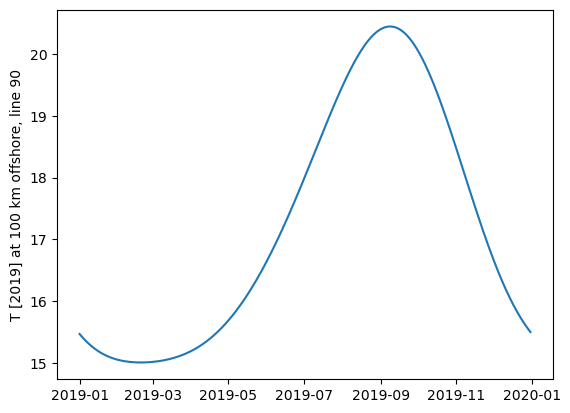

In [31]:
plt.clf()
ax = plt.gca()
ax.plot(dti, T_2019)
#
ax.set_ylabel('T [2019] at 100 km offshore, line 90')
plt.show()

## $\Delta T$/day

In [38]:
DT = T_2019 - np.roll(T_2019,1)
#DT[-1] = DT[-2]

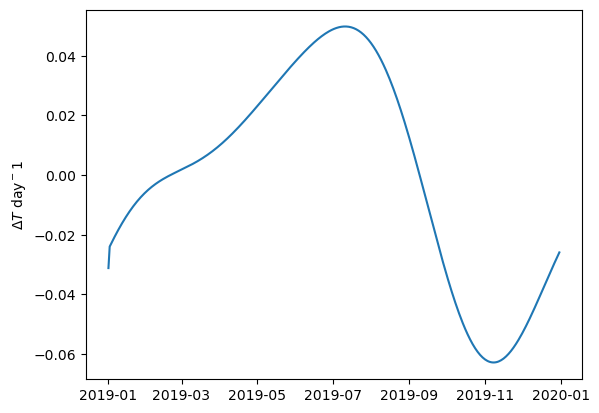

In [39]:
plt.clf()
ax = plt.gca()
ax.plot(dti, DT)
#
ax.set_ylabel(f'$\Delta T$ day$^{-1}$')
plt.show()